In [96]:
# prepare dataset
import pickle
import numpy as np
import pandas as pd
import scipy.stats
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl

file = './data/10334-1.csv'

def remove_outliers(x):
    '''Function for removing outliers from skewed data using Tukey's method after Box-Cox transform'''
    x, _ = scipy.stats.boxcox(x) # normalize distribution shape
    q1 = np.quantile(x, 0.25)
    q3 = np.quantile(x, 0.75)
    iqr = q3-q1
    idx = x<(q3+(1.5*iqr))
    return idx

def prepare_data(filepath,
                 dropdup = 1,
                 dropna = 1,
                 remove_outlier = 1):
    
    # read data
    df = pd.read_csv(filepath)
    
    # only female gender
    df = df[df['gender']=='F']
    df = df[df.unit=='u/ml'] # ensure correct units (makes no difference as seen below)
#     df = df[df['age']>=18] # age at least 18 following other studies
    
    # ensure float value
    df.value = np.array(df.value).astype(float)
    
    # preprocess
    if dropdup: # select most recent record per patient
        df['date'] = pd.to_datetime(df.date)
        df = df.sort_values(by='date', ascending=True)
        df = df.drop_duplicates(subset='id', keep='last') # remove multiple patient records
    if dropna: # drop NAs
        df = df.dropna(inplace=False, subset='value')
    if remove_outlier: # remove outliers
        pts_before_or = len(df)
        idx = remove_outliers(df.value.values)
        df = df[idx]
        print('Filtered out: '+str(1-len(df)/pts_before_or))
   
    return df

# official data for analysis
df = prepare_data(file, remove_outlier=1)



Filtered out: 0.015091385221781217


In [97]:
df.head()


,id,gender,age,date,year,month,day,name,loinc,value,unit
0,00c6d31a3529fdf068a170b20a1a3395,F,76,2018-01-02,2018,1,2,Cancer Ag 125 level (Serum),10334-1,41.9,u/ml
23,fbc40165e9a2d6f50db9f08edb3c38e6,F,23,2018-01-02,2018,1,2,Cancer Ag 125 level (Serum),10334-1,36.5,u/ml
22,f45b6f98348fb127621ab8850250f344,F,77,2018-01-02,2018,1,2,Cancer Ag 125 level (Serum),10334-1,66.2,u/ml
19,d3b5d202bcf8fe3a1117e21796c83e02,F,74,2018-01-02,2018,1,2,Cancer Ag 125 level (Serum),10334-1,6.9,u/ml
16,a1481f428e7fdefa3391910524e622b2,F,13,2018-01-02,2018,1,2,Cancer Ag 125 level (Serum),10334-1,21.2,u/ml


In [98]:
data = df[['age', 'value']].values
data.shape


(36482, 2)

In [261]:
# define grid for plotting contours
x_min = 18
x_max = 95
y_min = 0
y_max = 80
x_grid, y_grid = np.mgrid[x_min : x_max : 100j, y_min : y_max : 100j,]
positions = np.vstack([x_grid.ravel(), y_grid.ravel()])

# compute
kde = scipy.stats.gaussian_kde(data.T, bw_method='scott')
kde = kde(positions).reshape(x_grid.shape)
kde = (kde - kde.min()) / (kde.max() - kde.min())
# for i in range(kde.shape[0]):
#     kde[i,:] = (kde[i,:]-kde[i,:].min()) / (kde[i,:].max()-kde[i,:].min())


In [262]:
# load NN predictions
results_nn_dict = pickle.load(open('./neural_net/predictions_age.pkl', 'rb'))
nn_ris = np.array([np.array(results_nn_dict[i]) for i in sorted(results_nn_dict.keys())])
age_bins = [18]+list(np.arange(25,90,5)) # bin edges for mostly 5-year intervals
fm = interpolate.interp1d(age_bins, nn_ris[:,0], kind='quadratic')
fl = interpolate.interp1d(age_bins, nn_ris[:,1], kind='quadratic')
fu = interpolate.interp1d(age_bins, nn_ris[:,2], kind='quadratic')


In [263]:
# for contour plots 
nlevels = 2000
compression = 0.6
levels = np.linspace(0.0, 1.0, num=nlevels)
scaled_levels = levels**compression
colors = mpl.colormaps['viridis'](scaled_levels)
# plt.plot(scaled_levels)


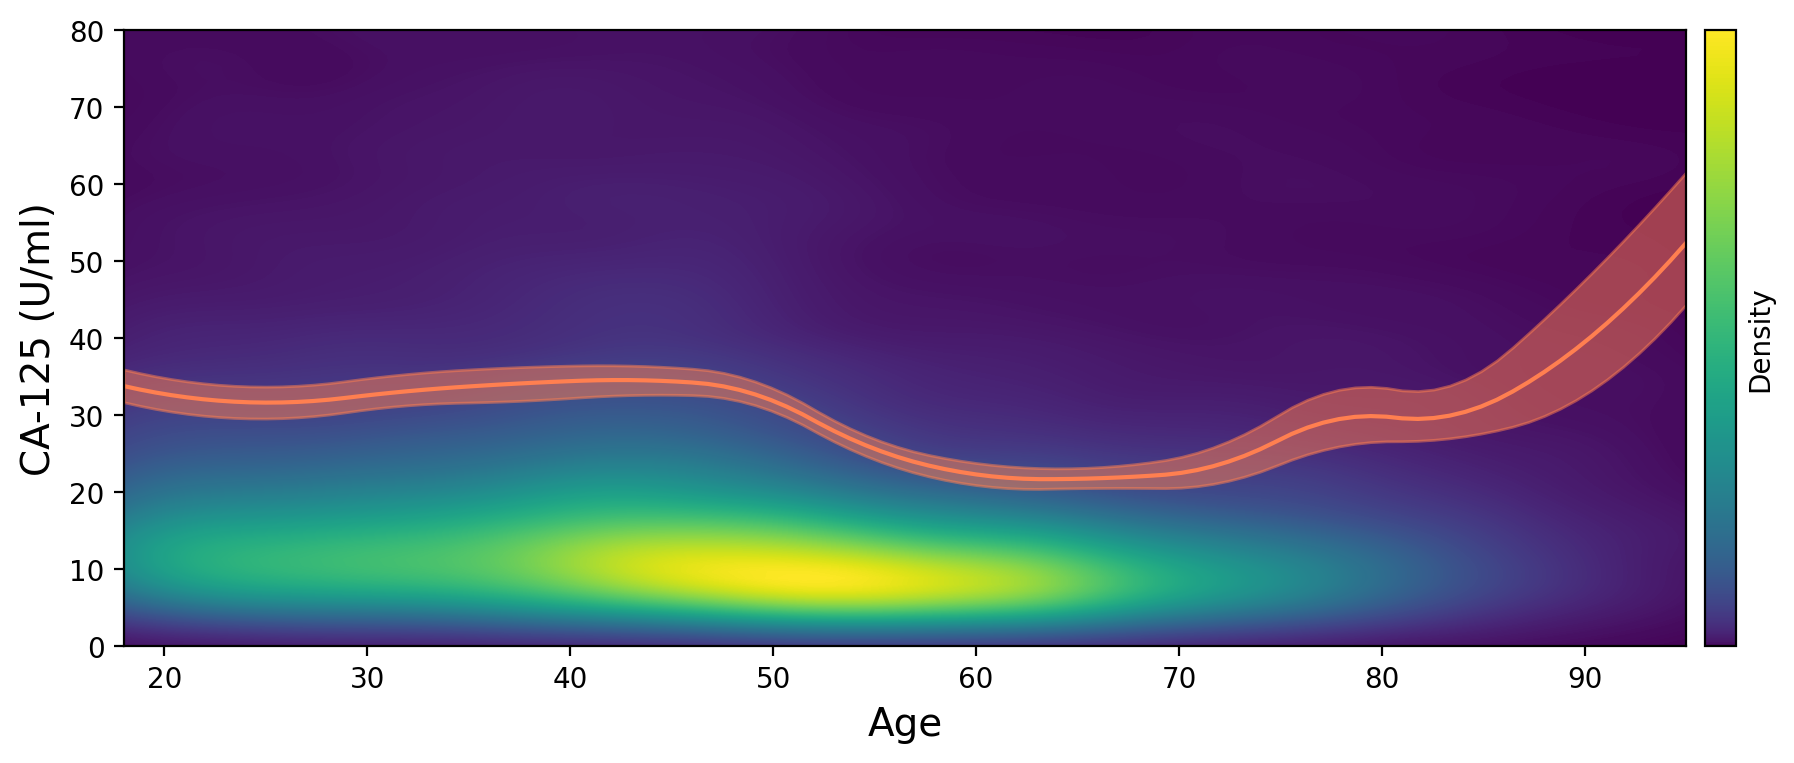

In [264]:
# plot
plt.figure(figsize=(12, 4), dpi=200)
plt.contourf(x_grid, y_grid, kde, colors=colors, levels=levels)
cbar = plt.colorbar(label='Density', pad=0.01);
cbar.set_ticks([])
plt.clim([0, 1])
plt.xlabel('Age', fontsize=14)
plt.ylabel('CA-125 (U/ml)', fontsize=14)

x = np.linspace(18, 85, 100)
plt.fill_between(np.linspace(18, 95, 100), fl(x), fu(x), color='coral', alpha=0.5);
plt.plot(np.linspace(18, 95, 100), fm(x), color='coral');
